In [ ]:
import pandas as pd
import glob,re,os
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data = {
    'airvis': pd.read_csv('restaurant/air_visit_data.csv'),
    'airres': pd.read_csv('restaurant/air_reserve.csv'),
    'airinfo': pd.read_csv('restaurant/air_store_info.csv'),
    'hpgres': pd.read_csv('restaurant/hpg_reserve.csv'),
    'hpginfo': pd.read_csv('restaurant/hpg_store_info.csv'),
    're': pd.read_csv('restaurant/store_id_relation.csv'),
    'sample': pd.read_csv('restaurant/sample_submission.csv'),
    'hol': pd.read_csv('restaurant/date_info.csv')
}

In [ ]:
data['hpgres']=data['hpgres'].merge(data['re'],on=['hpg_store_id'],how='inner')

In [ ]:
data['hpgres'] = data['hpgres'].rename(columns={'visit_datetime': 'visit_date'})
data['airres'] = data['airres'].rename(columns={'visit_datetime': 'visit_date'})

In [ ]:
data['hpgres'].tail()

In [ ]:
for df in ['airres','hpgres']:
    data[df]['visit_date'] = pd.to_datetime(data[df]['visit_date']).dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime']).dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_date'] - r['reserve_datetime']).days, axis=1)
    temp1 = data[df].groupby(['air_store_id','visit_date'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'reserve_datetime_diff': 'sum of diff', 'reserve_visitors': 'sum of res vistors'})
    temp2 = data[df].groupby(['air_store_id','visit_date'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'reserve_datetime_diff': 'mean of diff', 'reserve_visitors':'mean of res visitors'})
    data[df]=temp1.merge(temp2,how='inner',on=['air_store_id','visit_date'])

In [ ]:
data['airres'].tail()

In [ ]:
data['airvis']['visit_date']=pd.to_datetime(data['airvis']['visit_date'])
data['airvis']['dow']=data['airvis']['visit_date'].dt.dayofweek
data['airvis']['year']=data['airvis']['visit_date'].dt.year
data['airvis']['month']=data['airvis']['visit_date'].dt.month
data['airvis']['visit_date']=data['airvis']['visit_date'].dt.date

In [ ]:
data['airvis'].tail()

In [ ]:
data['sample']['visit_date'] = data['sample']['id'].map(lambda x: str(x).split('_')[2])
data['sample']['air_store_id'] = data['sample']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['sample']['visit_date'] = pd.to_datetime(data['sample']['visit_date'])
data['sample']['dow'] = data['sample']['visit_date'].dt.dayofweek
data['sample']['year'] = data['sample']['visit_date'].dt.year
data['sample']['month'] = data['sample']['visit_date'].dt.month
data['sample']['visit_date'] = data['sample']['visit_date'].dt.date

In [ ]:
data['sample'].head()

In [ ]:
unique_stores=data['sample']['air_store_id'].unique()
print('The number of unique stores is:', unique_stores.shape[0])
print('total number of data records in test set is',data['sample'].shape[0])

In [ ]:
stores=pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)],
            axis=0,ignore_index=True).reset_index(drop=True)

In [ ]:
data['airvis']['id_dow']=data['airvis'].apply(lambda x: '_'.join([str(x['air_store_id']),str(x['dow'])]),axis=1)
data['airvis']=data['airvis'].set_index('id_dow')
data['sample']['id_dow']=data['sample'].apply(lambda x: '_'.join([str(x['air_store_id']),str(x['dow'])]),axis=1)
data['sample']=data['sample'].set_index('id_dow')

In [ ]:
data['sample'].tail()

In [ ]:
temp=data['airvis'].groupby(['air_store_id','dow']).agg({'visitors':[np.min, np.mean, np.median, np.max, np.size]}).reset_index()
temp.head()

In [ ]:
temp.columns = ['air_store_id', 'dow', 'min_visitors', 'mean_visitors', 'median_visitors','max_visitors','count_observations']
stores=stores.merge(temp, on=['air_store_id','dow'],how='left')
stores.tail()

In [ ]:
stores = pd.merge(stores, data['airinfo'], how='left', on=['air_store_id'])
stores.tail()

In [ ]:
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
stores.tail()

In [ ]:
from sklearn import *
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

stores['air_genre_name'].unique()

In [ ]:
train=train.merge(stores,how='left',on=['air_store_id','dow'])
test=test.merge(stores,how='left',on=['air_store_id','dow'])

In [ ]:
for df in ['airres','hpgres']:
    train = pd.merge(train, data[df], on=['air_store_id','visit_date'], how='left')
    test = pd.merge(test, data[df], on=['air_store_id', 'visit_date'], how='left')

In [ ]:
train = train.fillna(-1)
test = test.fillna(-1)

In [ ]:
train.tail()

In [ ]:
test.tail()

In [ ]:
features = [f for f in train if f not in ['air_store_id', 'visit_date', 'visitors']]

In [ ]:
train = train.sort_values('visit_date')

In [ ]:
train.head()

In [ ]:
import pickle
with open('train.pickle', 'rb') as r:
    train = pickle.load(r)
with open('test.pickle', 'rb') as r:
    test = pickle. load(r)

In [ ]:
train_size = int(len(train)*0.7)
test_size = len(train) - train_size
input_train = train[features][0:train_size]
input_test = train[features][train_size:len(train)]
train_visitors = train.visitors.values[0:train_size]
test_visitors = train.visitors.values[train_size:len(train)]


In [ ]:
len(train_visitors)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from sklearn.svm import SVR
import pickle
from scipy import stats

with open('train.pickle', 'rb') as r:
    train = pickle.load(r)
with open('test.pickle', 'rb') as r:
    test = pickle.load(r)
features = [f for f in train if f not in ['air_store_id', 'visit_date', 'visitors']]
train_size = int(len(train)*0.7)
test_size = len(train) - train_size
input_train = train[features][0:train_size]
input_test = train[features][train_size:len(train)]
train_visitors = train.visitors.values[0:train_size]
test_visitors = train.visitors.values[train_size:len(train)]

grid = RandomizedSearchCV(SVR(), {"C":stats.expon(scale=100), "gamma": stats.expon(scale=.1), 'kernel': ['rbf']})
grid.fit(input_train, np.log1p(train_visitors))
print("The best parameters are %s with a score of %0.2f" %(grid.best_params_, grid.best_score_))

In [ ]:
from sklearn import svm
from sklearn.svm import SVR
import pickle
with open('train.pickle', 'rb') as r:
    train = pickle.load(r)
with open('test.pickle', 'rb') as r:
    test = pickle.load(r)
features = [f for f in train if f not in ['air_store_id', 'visit_date', 'visitors']]
train_size = int(len(train)*0.7)
test_size = len(train) - train_size
input_train = train[features][0:train_size]
input_test = train[features][train_size:len(train)]
train_visitors = train.visitors.values[0:train_size]
test_visitors = train.visitors.values[train_size:len(train)]
clf = svm.SVR(C=10, cache_size=300, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
clf.fit(input_train, train_visitors) 
pred3 = clf.predict(input_test)
with open('svm_test_C10_gamma0_1_poly.pickle', 'wb') as w:
    pickle.dump(pred3, w)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
mean_squared_error(test_visitors, pred3)  

In [ ]:
import math
import matplotlib.pyplot as plt
pre, = plt.plot(pred2[100:200])
trueValue, = plt.plot(test_visitors[100:200])
plt.xlabel('time')
plt.ylabel('visitors')
plt.show()

In [ ]:
import pickle
with open('svm_test_C1_gamma0_1_poly.pickle', 'wb') as w:
    pickle.dump(pred3, w)

In [1]:
import pickle
with open('svm_test_C1_gammaAuto_rbf.pickle', 'rb') as r:
    svm_rbf1 = pickle.load(r)
with open('svm_test_C10_gamma0_001_rbf.pickle', 'rb') as r:
    svm_rbf2 = pickle.load(r)
with open('svm_test_C1_gamma0_1_poly.pickle', 'rb') as r:
    svm_poly1 = pickle.load(r)  
with open('train.pickle', 'rb') as r:
    train = pickle.load(r)
train_size = int(len(train)*0.7)
test_visitors = train.visitors.values[train_size:len(train)]

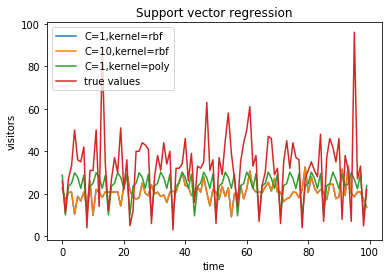

In [10]:
import math
import matplotlib.pyplot as plt
rbf1, = plt.plot(svm_rbf1[0:100])
rbf2, = plt.plot(svm_rbf2[0:100])
poly, = plt.plot(svm_poly1[0:100])
trueV, = plt.plot(test_visitors[0:100])
plt.xlabel('time')
plt.ylabel('visitors')
plt.legend([rbf1, rbf2, poly, trueV], ['C=1,kernel=rbf', 'C=10,kernel=rbf', 'C=1,kernel=poly', 'true values'], loc='upper left')
plt.title('Support vector regression')
plt.show()

In [11]:
plt.savefig('svr.eps', format='eps', dpi=1000)

In [12]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_visitors, svm_poly1) 

242.44329667149077

In [2]:
import pickle
with open('rfr_test_tree34.pickle', 'rb') as r:
    rfr = pickle.load(r)
with open('lasso_test_alpha0_01.pickle', 'rb') as r:
    lasso = pickle.load(r)

In [3]:
import math
rfr_error = []
lasso_error = []
svm_poly_error = []
svm_rbf_error = []
for i in range(len(rfr)):
    error1 = math.pow((rfr[i] - test_visitors[i]), 2)
    rfr_error.append(error1)
    error2 = math.pow((lasso[i] - test_visitors[i]), 2)
    lasso_error.append(error2)
    error3 = math.pow((svm_poly1[i] - test_visitors[i]), 2)
    svm_poly_error.append(error3)
    error4 = math.pow((svm_rbf1[i] - test_visitors[i]), 2)
    svm_rbf_error.append(error4)


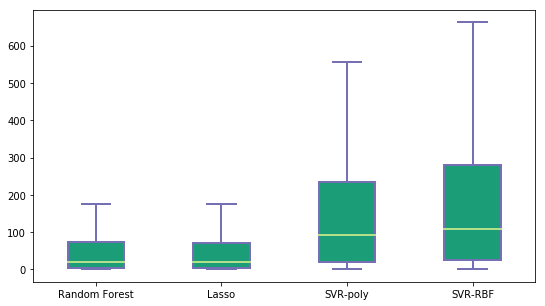

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(9, 5))
ax = fig.add_subplot(111)
#plt.boxplot([rfr, lasso, svm_poly1, svm_rbf1], 0, '')
bp = ax.boxplot([rfr_error, lasso_error, svm_poly_error, svm_rbf_error], 0, '', patch_artist=True)
ax.set_xticklabels(['Random Forest', 'Lasso', 'SVR-poly', 'SVR-RBF'])
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)
plt.savefig('boxplot.png')
plt.show()

In [36]:
len(svm_rbf1)

75633